Name: Karel Mackenzie Chandra
Student ID:30373867

### 1. Streaming data visualization

In [1]:
# import statements
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import time
# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

In [2]:
topic = 'EventProducer01'

In [3]:
# Use to define the max and minn value for y and x
def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Date={}, Temperature={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Date={}, Temperature={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

In [4]:
def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

In [5]:
# initialize of line plot 
def init_plots():
    try:
        width = 15
        height = 8
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization with interesting points') # giving figure a title
        ax.set_xlabel('Date')
        ax.set_ylabel('Temperature')
        ax.set_ylim(0,70) 
        ax.set_yticks([0,20,40,60])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))

In [6]:
# Received from the producer
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        # print('Waiting for messages')
        for message in consumer:
            data = eval(message.value.decode('utf-8'))
            if str(data.get('producer_num')) == 'Producer01':
                x.append(data.get('date')) 
                y.append(int(data.get('air_temperature_celcius')))
                # we start plotting only when we have 10 data points
                if len(y) > 10:
                    ax.clear()
                    ax.plot(x, y)
                    ax.set_xlabel('Date')
                    ax.set_ylabel('Temperature')
                    ax.set_ylim(0,70) 
                    ax.set_yticks([0,20,40,60])
                    annotate_max(x,y)
                    annotate_min(x,y)
                    fig.canvas.draw()
                    x.pop(0) # removing the item in the first position
                    y.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))

In [ ]:
if __name__ == '__main__':
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)

### 2. Static data visualization

In [7]:
import pymongo
from pymongo import MongoClient
from pprint import pprint

# Method 1: connect on the default host and port
client = MongoClient ()

In [8]:
db = client.fit3182_assignment_db # use database fit3182_assignment_db creatse from part A

In [9]:
Embedded = db.EMBEDDED

#### a.) Bar Chart

<IPython.core.display.Javascript object>


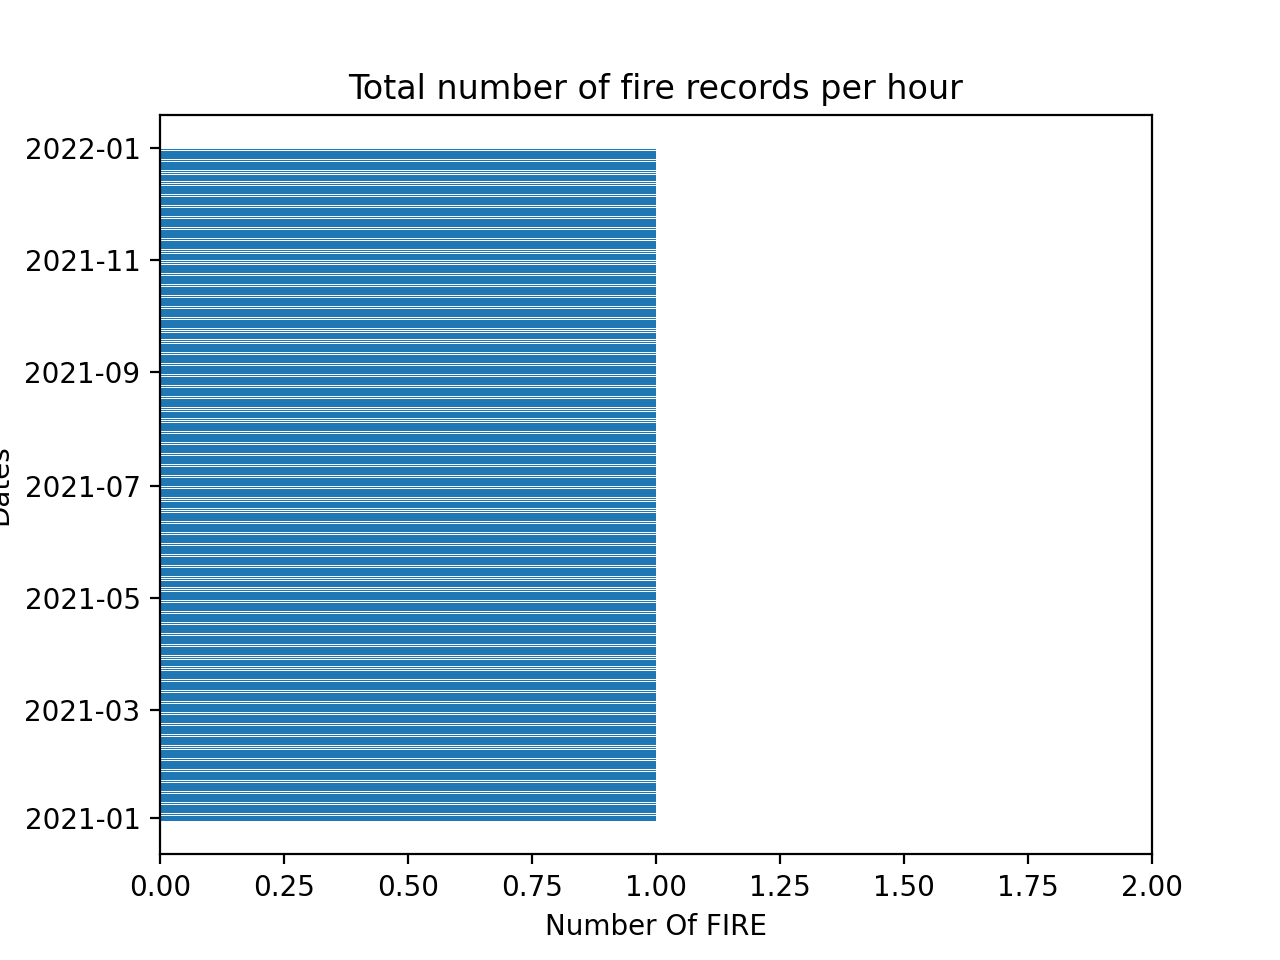

In [10]:
# Find the number of days per fire
x = []
Fire_Hour = Embedded.aggregate([
    {"$group" : {"_id" : "$date",
        "hotspots" : {"$sum": 1 } 
    }}
])
for i in Fire_Hour:
    x.append(i)

Hotspot = []
for value in x:
    Hotspot.append(value['hotspots'])

Dates = []
for d in x:
    Dates.append(d["_id"])
Dates = pd.to_datetime(Dates)

plt.barh(Dates, Hotspot)
plt.xlabel("Number Of FIRE") 
plt.xlim(0,2)
plt.ylabel("Dates") 
plt.title("Total number of fire records per hour")
plt.show()

#### b.) Map

pip install folium

In [11]:
import folium

In [12]:
# Preparing the data for plotting
hotspotList = []
# Looping through all the data
for row in Embedded.find():
    # Checking if their is hotspot
    if row['hotspots'] != []:
        #Adding the latitude and longitude and other attribut to the list of hotspots
        hotspotList.append( (float(row['hotspots'][0]['latitude']),
                             float(row['hotspots'][0]['longitude']),
                             int(row['air_temperature_celcius']),
                             int(row['GHI_w/m2']),
                             float(row['hotspots'][0]['surface_temperature_celcius']),
                             float(row['hotspots'][0]['confidence']),
                             float(row['relative_humidity'])))

In [13]:
# Map of melbourne
fomap = folium.Map(location=[-37.812015244225677, 144.951471202974], zoom_start=15)

In [14]:
tooltip = "Click me!"

In [15]:
# Put down the markers and tooltip for hotspot
for loc in hotspotList:
    if (loc[2] > 20 and loc[3] > 180):
        folium.Marker(
            location=[loc[0],loc[1]],
            popup="Natural Fire").add_to(fomap)
    else:
        folium.Marker(
            location=[loc[0],loc[1]],
            popup="Air Temp: "+str(loc[2]) +", " + 
                  "Surface_Temp: "+str(loc[4]) + ", " +
                  "Humidity: "+str(loc[6]) + ", " +
                  "Confidence: "+str(loc[5]),
            icon=folium.Icon(color="red")).add_to(fomap)
    

In [16]:
fomap